# Row-Aggregating Features In The Movielens Dataset

[Movielens](https://grouplens.org/datasets/movielens/) (F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1â€“19:19. https://doi.org/10.1145/2827872)

In [1]:
import os

from sklearn import base
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.despine()

import ibex
from ibex.sklearn import model_selection as pd_model_selection
from ibex.sklearn import linear_model as pd_linear_model
from ibex.sklearn import ensemble as pd_ensemble

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ratings = pd.read_csv(
    'movielens_data/ml-100k/u.data', 
    sep='\t', 
    header=None, 
    names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings['time'] = pd.to_datetime(ratings.timestamp * 1000000)
ratings.drop(['timestamp'], axis=1)
features = ['user_id', 'item_id', 'timestamp']
ratings.head()

,user_id,item_id,rating,timestamp,time
0,196,242,3,881250949,1970-01-11 04:47:30.949
1,186,302,3,891717742,1970-01-11 07:41:57.742
2,22,377,1,878887116,1970-01-11 04:08:07.116
3,244,51,2,880606923,1970-01-11 04:36:46.923
4,166,346,1,886397596,1970-01-11 06:13:17.596


In [3]:
len(ratings)

100000

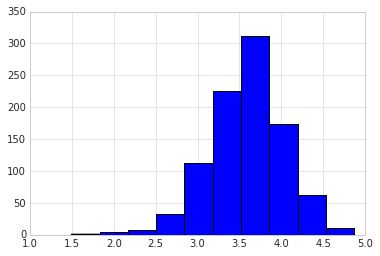

In [4]:
hist(ratings.rating.groupby(ratings.user_id).mean());

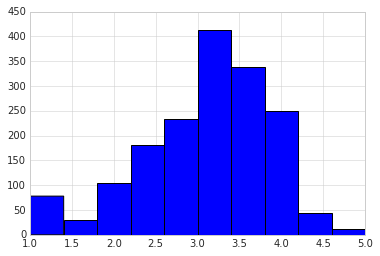

In [5]:
hist(ratings.rating.groupby(ratings.item_id).mean());

In [6]:
ratings.rating.std()

1.1256735991443161

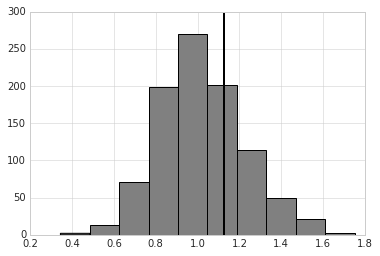

In [7]:
hist(
    ratings.rating.groupby(ratings.user_id).std(),
    color='grey');
axvline(
    ratings.rating.std(), 
    linewidth=2,
    color='black');

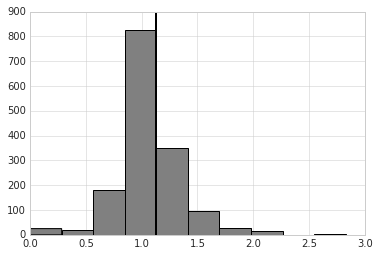

In [8]:
hist(
    ratings.rating.groupby(ratings.item_id).std().dropna(),
    color='grey');
axvline(
    ratings.rating.std(), 
    linewidth=2,
    color='black');

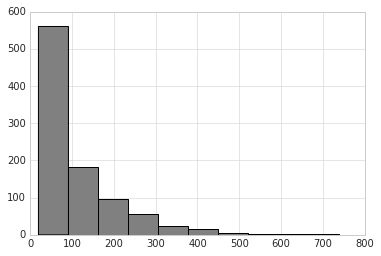

In [9]:
hist(
    ratings.rating.groupby(ratings.user_id).count(),
    color='grey');

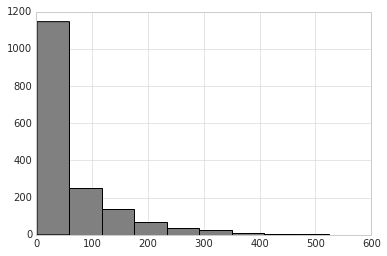

In [10]:
hist(
    ratings.rating.groupby(ratings.item_id).count(),
    color='grey');

In [11]:
class ScoresAggregator(base.BaseEstimator, base.TransformerMixin, ibex.FrameMixin):
    def fit(self, X, y):
        self._mean = y.mean()
        return self
        
    def transform(self, X):
        return pd.DataFrame({'mean': self._mean}, index=X.index)

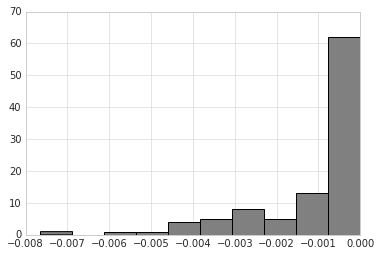

In [12]:
prd = ScoresAggregator() | pd_ensemble.RandomForestRegressor()
hist(
    pd_model_selection.cross_val_score(prd, ratings[features], ratings.rating, cv=100),
    color='grey');

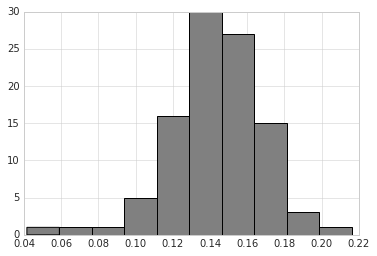

In [13]:
class ScoresAggregator(base.BaseEstimator, base.TransformerMixin, ibex.FrameMixin):
    def fit(self, X, y):
        self._mean = y.mean()
        self._user_id_stats = y.groupby(X.user_id).agg({'user_id_mean': np.mean, 'user_id_count': 'count'})
        self._item_id_stats = y.groupby(X.user_id).agg({'item_id_mean': np.mean, 'item_id_count': 'count'})
        return self
        
    def transform(self, X):
        user_ratings = pd.merge(
            X[['user_id']],
            self._user_id_stats,
            left_on='user_id',
            right_index=True,
            how='left')[['user_id_mean', 'user_id_count']]
        user_ratings.user_id_mean = user_ratings.user_id_mean.fillna(self._mean)
        return user_ratings
    

prd = ScoresAggregator() | pd_ensemble.RandomForestRegressor()
hist(
    pd_model_selection.cross_val_score(prd, ratings[features], ratings.rating, cv=100),
    color='grey');